# Implementing the WL-Optimal Assignment Kernel

### Import data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy import optimize
import networkx as nx
from hashlib import blake2b
from collections import Counter, defaultdict
import itertools
from tqdm import tqdm
import time
import pandas as pd
import grakel

In [2]:
train_path = "../data/training_data.pkl"
train_labels_path = "../data/training_labels.pkl"
test_path = "../data/test_data.pkl"

with open(train_path, "rb") as f:
    train_data = pickle.load(f)

with open(train_labels_path, "rb") as f:
    train_labels = pickle.load(f)

f.close()

train_data = np.array(train_data, dtype=object)
train_labels = np.array(train_labels, dtype=int)

In [3]:
train_labels_svm = train_labels.copy()
train_labels_svm[train_labels_svm == 0] = -1
np.unique(train_labels_svm)

array([-1,  1])

### Data visualization

In [4]:
import seaborn as sns

sns.set_style('whitegrid')

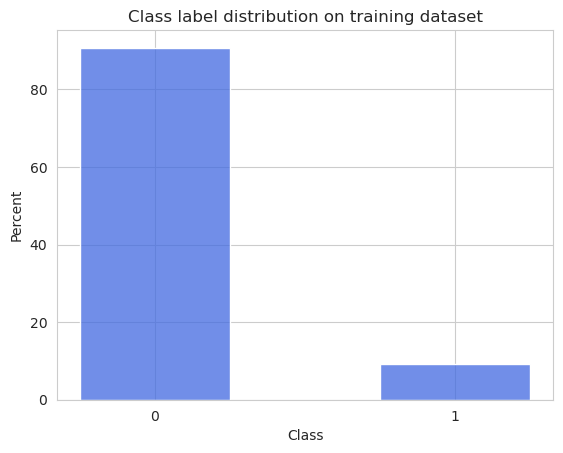

In [5]:
ax = sns.histplot(train_labels, stat='percent', discrete=True, shrink=.5, color='royalblue')
ax.set_xticks([0, 1])
ax.set(xlabel='Class',
       title='Class label distribution on training dataset')
plt.savefig('./docs/class_labels.png')
plt.show()

In [6]:
nb_nodes = np.array([len(x.nodes) for x in train_data])

In [7]:
median_nodes = np.median(nb_nodes)

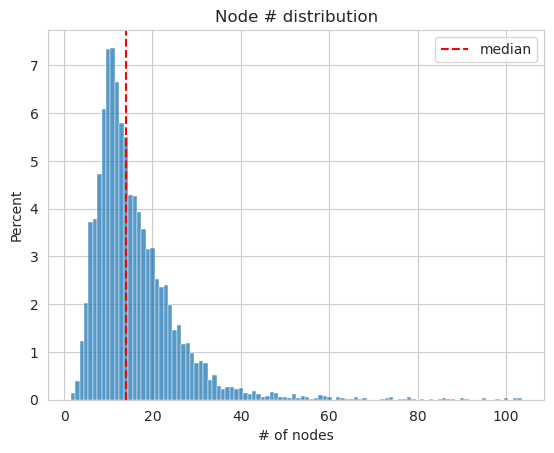

In [8]:
ax = sns.histplot(nb_nodes, stat='percent', discrete=True)
ax.set(xlabel='# of nodes',
       ylabel='Percent',
       title='Node # distribution')
ax.axvline(median_nodes, linestyle='--', c='red', label='median')
ax.legend()
plt.savefig('./docs/node_nb_distribution.png')
plt.show()

In [9]:
nb_edges = np.array([len(x.edges) for x in train_data])
median_edges = np.median(nb_edges)

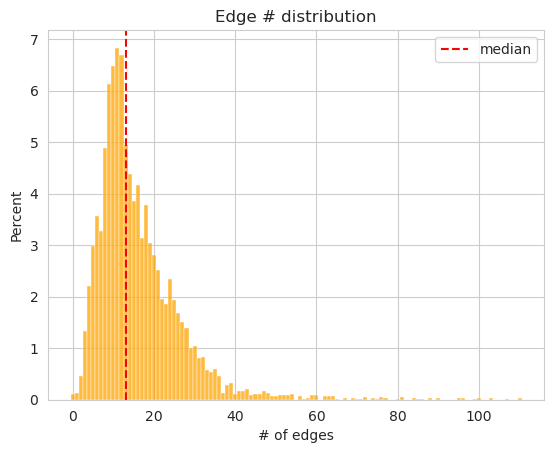

In [10]:
ax = sns.histplot(nb_edges, stat='percent', discrete=True, color='orange')
ax.set(xlabel='# of edges',
       ylabel='Percent',
       title='Edge # distribution')

ax.axvline(median_edges, linestyle='--', c='red', label='median')
ax.legend()
plt.savefig('./docs/edge_nb_distribution.png')
plt.show()

In [11]:
def extract_labels(g):
    g_ = dict(g.nodes(data=True))
    g_ = [val['labels'][0] for key, val in g_.items()]
    return g_
    
node_labels = np.hstack([extract_labels(x) for x in train_data])

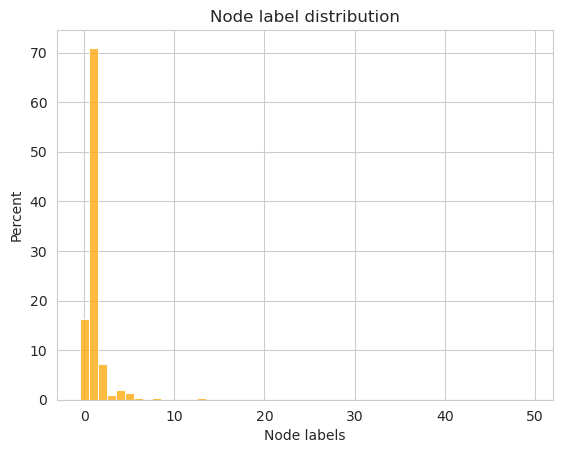

In [12]:
ax = sns.histplot(node_labels, stat='percent', discrete=True, color='orange')
ax.set(xlabel='Node labels',
       ylabel='Percent',
       title='Node label distribution')
plt.show()

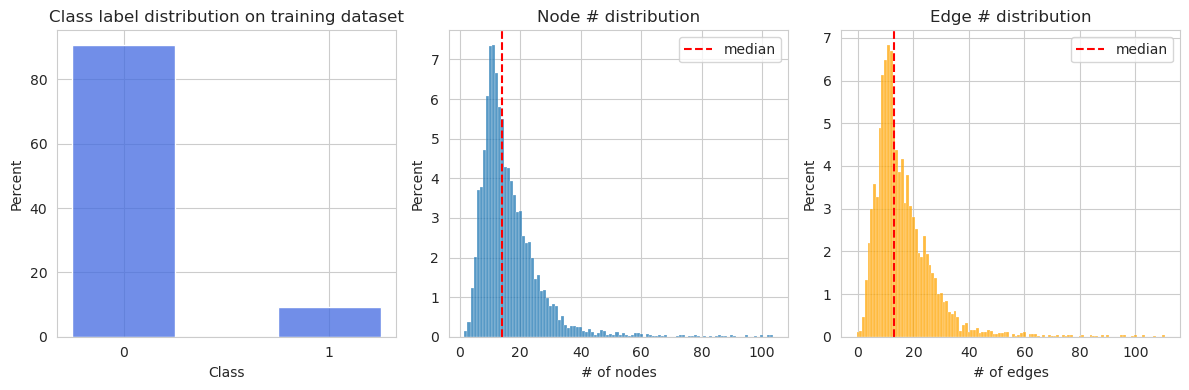

In [13]:
## figure for report
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1 = sns.histplot(train_labels,
                   stat='percent',
                   discrete=True,
                   shrink=.5,
                   color='royalblue',
                   ax=ax1)
ax1.set_xticks([0, 1])
ax1.set(xlabel='Class',
       title='Class label distribution on training dataset')

ax2 = sns.histplot(nb_nodes, stat='percent', discrete=True, ax=ax2)
ax2.set(xlabel='# of nodes',
       ylabel='Percent',
       title='Node # distribution')
ax2.axvline(median_nodes, linestyle='--', c='red', label='median')
ax2.legend()

ax3 = sns.histplot(nb_edges, stat='percent', discrete=True, color='orange',
                   ax=ax3)
ax3.set(xlabel='# of edges',
       ylabel='Percent',
       title='Edge # distribution')

ax3.axvline(median_edges, linestyle='--', c='red', label='median')
ax3.legend()

fig.tight_layout()
plt.savefig('./docs/figure1_data_exploration.png', dpi=300)
plt.show()

## WLOA

In [ ]:
grakel_train = "../data/K_train_WL_OA_grakel.npy"
grakel_test = "../data/K_test_WL_OA_grakel.npy"

In [ ]:
class WLOptimalAssignment:
    '''
    The weisfeiler lehman optimal assigment kernel.
    Simplified and adapted from the Grakel library to work
    directly on networkx graphs.
    '''
    
    def __init__(self,
                 edge_attr="labels",
                 node_attr="labels",
                 n_iter=5):
        self.n_iter = n_iter
        
    def prepare_input(self,
                      G):
        '''
        Parameters
        -----------
            G: a list of networkx graphs
        
        Returns
        -----------
            H: a numpy array with the graph histograms
        '''
        
        # Initialize hierarchy
        self._hierarchy = dict()
        self._hierarchy['root'] = dict()
        self._hierarchy['root']['parent'] = None
        self._hierarchy['root']['children'] = list()
        self._hierarchy['root']['w'] = 0
        self._hierarchy['root']['omega'] = 0
        
        WL_inverse_labels = dict()
        label_count = 0
        
        
        